# HW3 Mean Shift

Original jupyter notebook is uploaded at [GitHub](https://github.com/zhuo34/csmath2022).

Generate Gaussian distributions by [Box-Muller Transform](https://en.wikipedia.org/wiki/Box%E2%80%93Muller_transform).

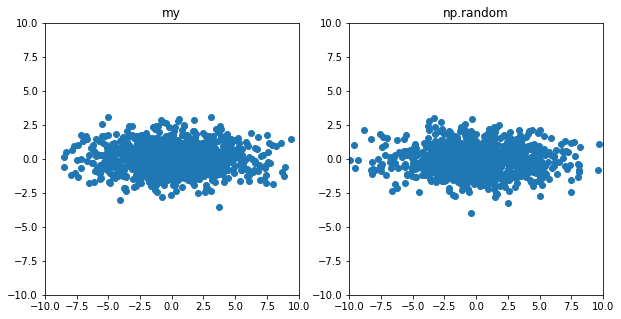

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def normal(mu=0, sigma=1, size=1):
    u = 1 - np.random.uniform(size=size)
    v = np.random.uniform(size=size)
    z = np.sqrt(-2*np.log(u)) * np.cos(2*np.pi*v)
    return mu + z*sigma

def multivariate_normal(mean, cov, size=1):
    z = normal(size=(size, len(mean)))
    z = mean + z @ np.sqrt(cov)
    return z
mean = np.array([0, 0])
cov = np.array([[10, 0], [0, 1]])
z = multivariate_normal(mean, cov, 1000)
z1 = np.random.multivariate_normal(mean, cov, 1000)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
plt.title("multivariate normal")
ax[0].set_title("my")
ax[0].set_xlim(-10, 10)
ax[0].set_ylim(-10, 10)
ax[0].scatter(z[:, 0], z[:, 1])

ax[1].set_title("np.random")
ax[1].set_xlim(-10, 10)
ax[1].set_ylim(-10, 10)
ax[1].scatter(z1[:, 0], z1[:, 1])
plt.show()

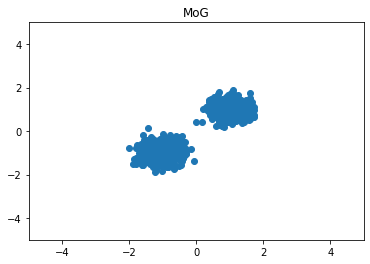

In [2]:
def mog(params, p, size):
    if len(params) != len(p):
        raise Exception("Number mismatch.")
    z = []
    cnt = np.zeros(len(p))
    for _ in range(size):
        p = p / np.sum(p)
        pp = np.cumsum(p)
        a = np.random.uniform()
        idx = np.argmax(a - pp < 0)
        mean, cov = params[idx]
        cnt[idx] += 1
        z.append(multivariate_normal(mean, cov, 1))
    return np.vstack(z)


mean1, cov1 = np.array([-1,-1]), np.array([[0.1, 0], [0, 0.1]])
mean2, cov2 = np.array([1, 1]), np.array([[0.1, 0], [0, 0.1]])

z = mog([[mean1, cov1], [mean2, cov2]], [0.5, 0.5], size=1000)
plt.title("MoG")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.scatter(z[:, 0], z[:, 1])
plt.show()

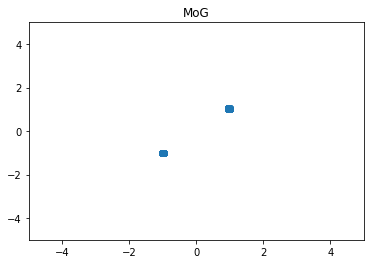

In [3]:
class MeanShift:
    def __init__(self, kernel_fn: str=None):
        self.kernel = self._guassian_kernel
        self.MIN_DISTANCE = 1e-4

    @classmethod
    def _guassian_kernel(self, distance, bandwidth):
        return (1 / (np.sqrt(2 * np.pi) * bandwidth)) * np.exp(-0.5 * (distance / bandwidth) ** 2)

    def fit_transform(self, X: np.ndarray, bandwidth=1):
        if X.ndim != 2:
            raise Exception("`X` should have shape of [N, d]")
        N, d = X.shape
        shifting = [True] * N
        max_shift_dis = 1
        X_shift = X.copy()
        
        cnt = 0
        while max_shift_dis > self.MIN_DISTANCE:
            max_shift_dis = 0
            for i, p in enumerate(X_shift):
                # print(p)
                if not shifting[i]:
                    continue
                # calculate distance
                dis = np.sum((p - X) ** 2, axis=1) # [1, N]
                # kernel
                weights = self.kernel(dis, bandwidth) # [1, N]
                p_shifted = weights @ X / np.sum(weights)
                # d
                delta = np.sum((p - p_shifted) ** 2)
                max_shift_dis = max(max_shift_dis, delta)
                shifting[i] = delta > self.MIN_DISTANCE
                # update shifted X
                X_shift[i] = p_shifted
            cnt += 1
        return X_shift

ms = MeanShift()
z_shift = ms.fit_transform(z, bandwidth=.1)
plt.title("MoG")
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.scatter(z_shift[:, 0], z_shift[:, 1])
plt.show()